In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.irf import IRAnalysis
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import kpss
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Load the data
df = pd.read_csv('../data/processed/eth_regression_data.csv')

# Convert week_start to datetime
df['week_start'] = pd.to_datetime(df['week_start'])
df = df.sort_values('week_start').reset_index(drop=True)

# print("Dataset shape:", df.shape)
# print("Date range:", df['week_start'].min(), "to", df['week_start'].max())
# print("\nFirst few rows:")
# print(df.head())

In [36]:
# =============================================================================
# STEP 1: STATIONARITY TESTING
# =============================================================================

# Test key variables for stationarity
variables_to_test = {
    'weekly_vol_annualized': 'ETH Volatility (Annualized)',
    'market_weekly_vol_annualized': 'Market Volatility (Annualized)',
    'top1_centrality': 'Top 1% Centrality',
    'top3_centrality': 'Top 3% Centrality', 
    'top5_centrality': 'Top 5% Centrality',
    'top10_centrality': 'Top 10% Centrality',
    'hhi': 'Herfindahl-Hirschman Index',
    'gini': 'Gini Coefficient'
}

stationarity_results = {}

print("\n" + "="*80)
print("STATIONARITY TESTING")
print("="*80)

for var, name in variables_to_test.items():
    print(f"\n=== Testing {name} ({var}) ===")
    
    series = df[var].dropna()
    
    # ADF Test (H0: non-stationary, i.e., has unit root)
    adf_result = adfuller(series, autolag='AIC')
    print(f"ADF Test:")
    print(f"  Test Statistic: {adf_result[0]:.4f}")
    print(f"  p-value: {adf_result[1]:.4f}")
    print(f"  Critical Values (1%, 5%, 10%): {adf_result[4]}")
    adf_stationary = adf_result[1] < 0.05
    print(f"  Stationary (ADF): {'Yes' if adf_stationary else 'No'}")
    
    # KPSS Test (H0: stationary around trend)
    try:
        kpss_result = kpss(series, regression='c')
        print(f"KPSS Test:")
        print(f"  Test Statistic: {kpss_result[0]:.4f}")
        print(f"  p-value: {kpss_result[1]:.4f}")
        print(f"  Critical Values (10%, 5%, 2.5%, 1%): {kpss_result[3]}")
        kpss_stationary = kpss_result[1] > 0.05
        print(f"  Stationary (KPSS): {'Yes' if kpss_stationary else 'No'}")
        
        # Combined conclusion
        if adf_stationary and kpss_stationary:
            conclusion = "STATIONARY"
        elif not adf_stationary and not kpss_stationary:
            conclusion = "NON-STATIONARY"
        else:
            conclusion = "INCONCLUSIVE - Consider first differencing"
        
    except Exception as e:
        print(f"  KPSS test failed: {e}")
        conclusion = "STATIONARY" if adf_stationary else "NON-STATIONARY"
    
    print(f"  Final Conclusion: {conclusion}")
    stationarity_results[var] = {
        'name': name,
        'adf_pvalue': adf_result[1],
        'adf_stationary': adf_stationary,
        'conclusion': conclusion
    }

# Summary of stationarity results
print("\n" + "="*50)
print("STATIONARITY SUMMARY")
print("="*50)
for var, result in stationarity_results.items():
    print(f"{result['name']}: {result['conclusion']} (ADF p-value: {result['adf_pvalue']:.4f})")



STATIONARITY TESTING

=== Testing ETH Volatility (Annualized) (weekly_vol_annualized) ===
ADF Test:
  Test Statistic: -3.6868
  p-value: 0.0043
  Critical Values (1%, 5%, 10%): {'1%': np.float64(-3.4769274060112707), '5%': np.float64(-2.8819726324025625), '10%': np.float64(-2.577665408088415)}
  Stationary (ADF): Yes
KPSS Test:
  Test Statistic: 0.6414
  p-value: 0.0189
  Critical Values (10%, 5%, 2.5%, 1%): {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
  Stationary (KPSS): No
  Final Conclusion: INCONCLUSIVE - Consider first differencing

=== Testing Market Volatility (Annualized) (market_weekly_vol_annualized) ===
ADF Test:
  Test Statistic: -10.2974
  p-value: 0.0000
  Critical Values (1%, 5%, 10%): {'1%': np.float64(-3.4756368462466662), '5%': np.float64(-2.8814104466172608), '10%': np.float64(-2.5773652982553568)}
  Stationary (ADF): Yes
KPSS Test:
  Test Statistic: 0.1511
  p-value: 0.1000
  Critical Values (10%, 5%, 2.5%, 1%): {'10%': 0.347, '5%': 0.463, '2.5%': 0.574

In [28]:
# =============================================================================
# STEP 2: FIRST DIFFERENCING (if needed)
# =============================================================================

# Create first differences for non-stationary variables
print("\n" + "="*80)
print("CREATING FIRST DIFFERENCES FOR NON-STATIONARY VARIABLES")
print("="*80)

non_stationary_vars = [var for var, result in stationarity_results.items() 
                      if result['conclusion'] in ['NON-STATIONARY', 'INCONCLUSIVE - Consider first differencing']]

print(f"Variables that may need differencing: {non_stationary_vars}")

# Create differenced versions
df_analysis = df.copy()
differenced_vars = {}

for var in non_stationary_vars:
    diff_var = f"{var}_diff"
    df_analysis[diff_var] = df_analysis[var].diff()
    differenced_vars[var] = diff_var
    
    # Test stationarity of differenced series
    print(f"\nTesting stationarity of differenced {var}:")
    series_diff = df_analysis[diff_var].dropna()
    adf_result = adfuller(series_diff, autolag='AIC')
    print(f"  ADF p-value: {adf_result[1]:.4f}")
    print(f"  Stationary: {'Yes' if adf_result[1] < 0.05 else 'No'}")


CREATING FIRST DIFFERENCES FOR NON-STATIONARY VARIABLES
Variables that may need differencing: ['weekly_vol_annualized', 'top1_centrality', 'top3_centrality', 'top5_centrality', 'top10_centrality', 'hhi', 'gini']

Testing stationarity of differenced weekly_vol_annualized:
  ADF p-value: 0.0000
  Stationary: Yes

Testing stationarity of differenced top1_centrality:
  ADF p-value: 0.0000
  Stationary: Yes

Testing stationarity of differenced top3_centrality:
  ADF p-value: 0.0000
  Stationary: Yes

Testing stationarity of differenced top5_centrality:
  ADF p-value: 0.0002
  Stationary: Yes

Testing stationarity of differenced top10_centrality:
  ADF p-value: 0.0000
  Stationary: Yes

Testing stationarity of differenced hhi:
  ADF p-value: 0.0000
  Stationary: Yes

Testing stationarity of differenced gini:
  ADF p-value: 0.0003
  Stationary: Yes



TIME SERIES VISUALIZATION


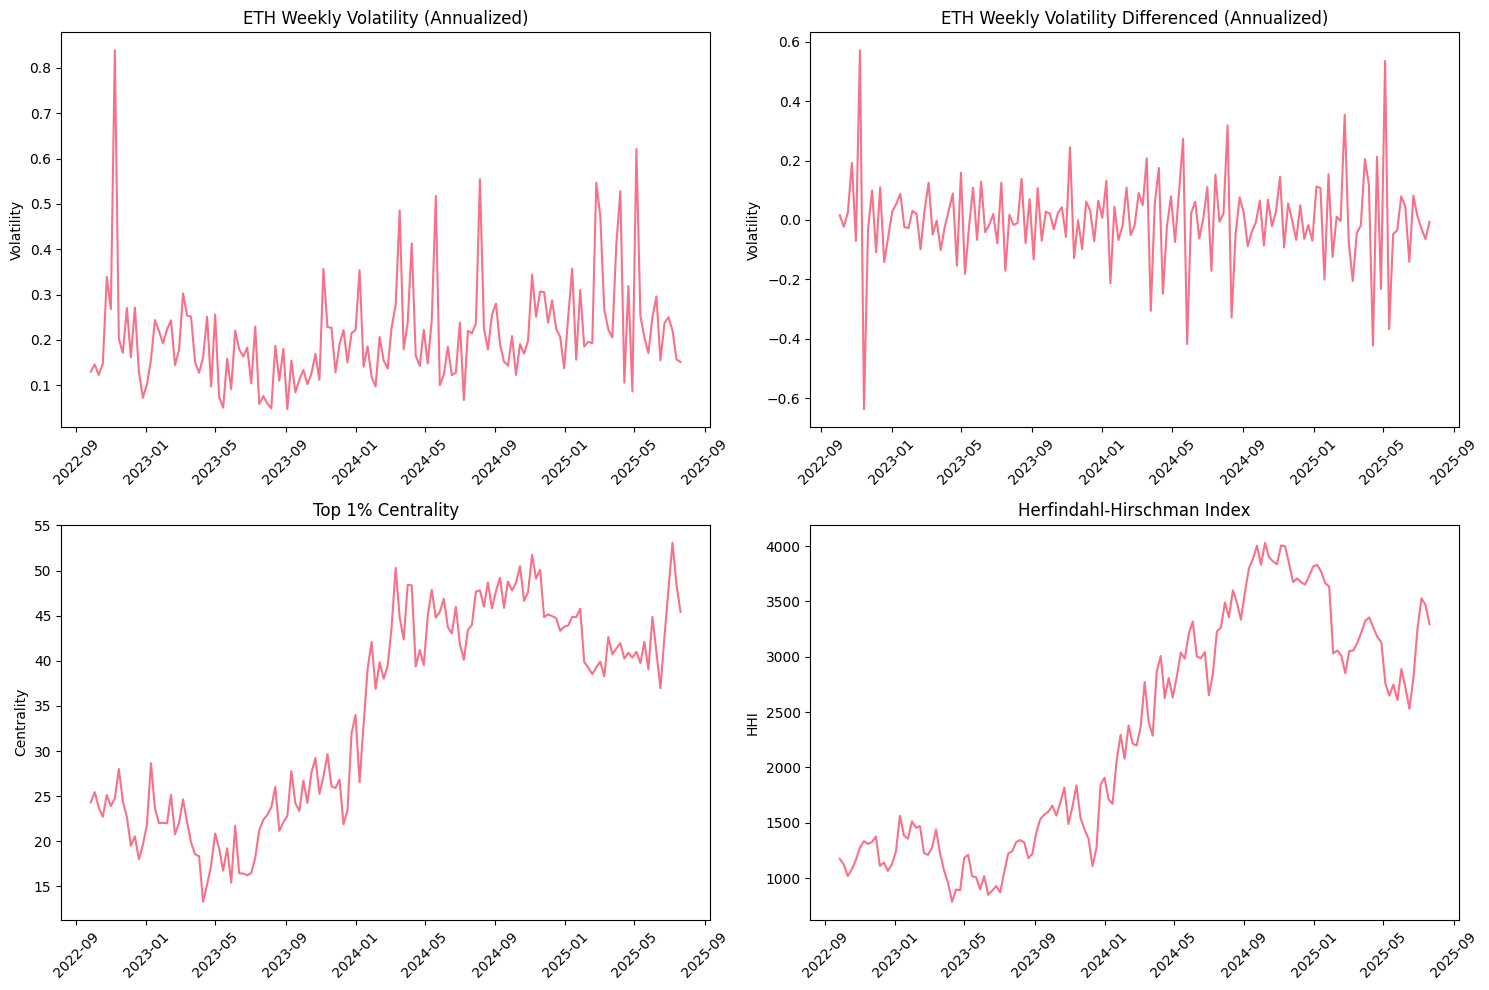

In [38]:
# =============================================================================
# STEP 3: VISUALIZATION OF TIME SERIES
# =============================================================================

print("\n" + "="*80)
print("TIME SERIES VISUALIZATION")
print("="*80)

# Plot volatility measures
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ETH Volatility
axes[0,0].plot(df['week_start'], df['weekly_vol_annualized'])
axes[0,0].set_title('ETH Weekly Volatility (Annualized)')
axes[0,0].set_ylabel('Volatility')
axes[0,0].tick_params(axis='x', rotation=45)

# ETH Volatility Differenced
axes[0,1].plot(df_analysis['week_start'], df_analysis['weekly_vol_annualized_diff'])
axes[0,1].set_title('ETH Weekly Volatility Differenced (Annualized)')
axes[0,1].set_ylabel('Volatility')
axes[0,1].tick_params(axis='x', rotation=45)


# Top 1% Centrality
axes[1,0].plot(df['week_start'], df['top1_centrality'])
axes[1,0].set_title('Top 1% Centrality')
axes[1,0].set_ylabel('Centrality')
axes[1,0].tick_params(axis='x', rotation=45)

# HHI
axes[1,1].plot(df['week_start'], df['hhi'])
axes[1,1].set_title('Herfindahl-Hirschman Index')
axes[1,1].set_ylabel('HHI')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [67]:
print("\n" + "="*80)
print("GRANGER CAUSALITY ANALYSIS")
print("="*80)

# Define variables for Granger causality testing
volatility_var = 'weekly_vol_annualized'
centrality_vars = ['top1_centrality_diff', 'top3_centrality_diff', 'top5_centrality_diff', 
                   'top10_centrality_diff', 'hhi_diff', 'gini_diff']

# Test each centrality variable against volatility
granger_results = {}

for centrality_var in centrality_vars:
    print(f"\n{'='*60}")
    print(f"Testing: Does {centrality_var} Granger-cause {volatility_var}?")
    print(f"H0: {centrality_var} does NOT Granger-cause {volatility_var}")
    print(f"{'='*60}")
    
    # Create dataframe with the two variables (remove NaN values)
    test_data = df_analysis[[centrality_var, volatility_var]].dropna()
    
    # Granger causality test (test multiple lags)
    max_lags = min(8, len(test_data)//10)  # Use max 8 lags or 10% of sample size
    
    try:
        gc_result = grangercausalitytests(test_data, maxlag=max_lags, verbose=False)
        
        print(f"Sample size: {len(test_data)} observations")
        print(f"Testing lags 1 to {max_lags}")
        print("\nResults by lag:")
        
        # Extract p-values for each lag
        lag_results = {}
        for lag in range(1, max_lags + 1):
            # Get F-test p-value (most common test)
            f_test_pval = gc_result[lag][0]['ssr_ftest'][1]
            lag_results[lag] = f_test_pval
            
            significance = "***" if f_test_pval < 0.01 else "**" if f_test_pval < 0.05 else "*" if f_test_pval < 0.1 else ""
            print(f"  Lag {lag}: F-test p-value = {f_test_pval:.4f} {significance}")
        
        # Overall assessment
        min_pval = min(lag_results.values())
        best_lag = min(lag_results, key=lag_results.get)
        
        print(f"\nBest result: Lag {best_lag} with p-value = {min_pval:.4f}")
        
        if min_pval < 0.05:
            print(f"CONCLUSION: {centrality_var} DOES Granger-cause {volatility_var} at 5% level")
        elif min_pval < 0.10:
            print(f"CONCLUSION: {centrality_var} WEAKLY Granger-causes {volatility_var} at 10% level")
        else:
            print(f"CONCLUSION: {centrality_var} does NOT Granger-cause {volatility_var}")
        
        granger_results[centrality_var] = {
            'min_pvalue': min_pval,
            'best_lag': best_lag,
            'significant_5pct': min_pval < 0.05,
            'significant_10pct': min_pval < 0.10
        }
        
    except Exception as e:
        print(f"Error testing {centrality_var}: {e}")
        granger_results[centrality_var] = {'error': str(e)}

# Summary of all results
print(f"\n{'='*80}")
print("GRANGER CAUSALITY SUMMARY")
print(f"{'='*80}")
print(f"{'Variable':<25} {'Min P-value':<12} {'Best Lag':<10} {'Significant?':<12}")
print(f"{'-'*60}")

for var, result in granger_results.items():
    if 'error' not in result:
        sig_text = "Yes (5%)" if result['significant_5pct'] else "Yes (10%)" if result['significant_10pct'] else "No"
        print(f"{var:<25} {result['min_pvalue']:<12.4f} {result['best_lag']:<10} {sig_text:<12}")
    else:
        print(f"{var:<25} {'ERROR':<12} {'-':<10} {'-':<12}")

print(f"\n{'='*60}")
print("INTERPRETATION:")
print("- Granger causality tests if past values of X help predict Y")
print("- Significant p-values (< 0.05) suggest X Granger-causes Y")
print("- This indicates predictive relationships, not necessarily true causation")
print(f"{'='*60}")


GRANGER CAUSALITY ANALYSIS

Testing: Does top1_centrality_diff Granger-cause weekly_vol_annualized?
H0: top1_centrality_diff does NOT Granger-cause weekly_vol_annualized
Sample size: 147 observations
Testing lags 1 to 8

Results by lag:
  Lag 1: F-test p-value = 0.0352 **
  Lag 2: F-test p-value = 0.1433 
  Lag 3: F-test p-value = 0.1122 
  Lag 4: F-test p-value = 0.1299 
  Lag 5: F-test p-value = 0.2027 
  Lag 6: F-test p-value = 0.0988 *
  Lag 7: F-test p-value = 0.0363 **
  Lag 8: F-test p-value = 0.0372 **

Best result: Lag 1 with p-value = 0.0352
CONCLUSION: top1_centrality_diff DOES Granger-cause weekly_vol_annualized at 5% level

Testing: Does top3_centrality_diff Granger-cause weekly_vol_annualized?
H0: top3_centrality_diff does NOT Granger-cause weekly_vol_annualized
Sample size: 147 observations
Testing lags 1 to 8

Results by lag:
  Lag 1: F-test p-value = 0.0675 *
  Lag 2: F-test p-value = 0.1628 
  Lag 3: F-test p-value = 0.2425 
  Lag 4: F-test p-value = 0.1072 
  Lag 5:

In [ ]:
print("\n" + "="*80)
print("VECTOR AUTOREGRESSION (VAR) ANALYSIS")
print("="*80)

# PREPARE DATA FOR VAR

# Define variables based on Granger causality results
# Use stationary variables (levels for already stationary, differenced for non-stationary)
endog_vars = [
    # 'weekly_vol_annualized',         # Non-Differenced 
    'market_weekly_vol_annualized',  
    'weekly_mean_return',            # Likely stationary (returns)
    'weekly_abs_return',              
    'market_weekly_return',          
    'eth_weekly_turnover',           
    'market_weekly_turnover',        
    'weekly_vol_annualized_diff'     # Differenced (now stationary)
]

# Network variables (only significant ones from Granger test)
network_vars = ['top1_centrality_diff']

# Combine all variables
all_vars = endog_vars + network_vars
var_ordering = all_vars  # This determines the Cholesky ordering

print(f"Endogenous variables: {endog_vars}")
print(f"Network variables: {network_vars}")
print(f"VAR ordering: {var_ordering}")

# Prepare data
var_data = df_analysis[all_vars].dropna()
print(f"\nSample size after removing NaN: {len(var_data)} observations")
print(f"Sample period: {df_analysis.loc[var_data.index[0], 'week_start']} to {df_analysis.loc[var_data.index[-1], 'week_start']}")

# Standardize variables (optional but recommended)
var_data_scaled = pd.DataFrame(
    (var_data - var_data.mean()) / var_data.std(),
    columns=var_data.columns,
    index=var_data.index
)


VECTOR AUTOREGRESSION (VAR) ANALYSIS
Endogenous variables: ['market_weekly_vol_annualized', 'weekly_mean_return', 'weekly_abs_return', 'market_weekly_return', 'eth_weekly_turnover', 'market_weekly_turnover', 'weekly_vol_annualized_diff']
Network variables: ['top1_centrality_diff']
VAR ordering: ['market_weekly_vol_annualized', 'weekly_mean_return', 'weekly_abs_return', 'market_weekly_return', 'eth_weekly_turnover', 'market_weekly_turnover', 'weekly_vol_annualized_diff', 'top1_centrality_diff']

Sample size after removing NaN: 147 observations
Sample period: 2022-10-03 00:00:00 to 2025-07-21 00:00:00


In [65]:
print(f"\n{'='*60}")
print("ESTIMATING VAR MODEL")
print(f"{'='*60}")

# Fit VAR model
model = VAR(var_data_scaled)

# Select optimal lag length
lag_selection = model.select_order(maxlags=8)
print("Lag selection criteria:")
for criterion, lags in lag_selection.selected_orders.items():
    print(f"  {criterion}: {lags} lags")

# Use AIC-selected lag (or manually choose)
optimal_lags = lag_selection.selected_orders['aic']
print(f"\nUsing {optimal_lags} lags (AIC criterion)")

# Estimate VAR
var_model = model.fit(optimal_lags)
print(f"\nVAR({optimal_lags}) model estimated successfully")
print(f"Model summary:")
print(f"  Number of equations: {var_model.neqs}")
print(f"  Number of observations used: {var_model.nobs}")
print(f"  Number of parameters: {var_model.k_ar * var_model.neqs + var_model.neqs}")



ESTIMATING VAR MODEL
Lag selection criteria:
  aic: 2 lags
  bic: 1 lags
  hqic: 1 lags
  fpe: 2 lags

Using 2 lags (AIC criterion)

VAR(2) model estimated successfully
Model summary:
  Number of equations: 8
  Number of observations used: 145
  Number of parameters: 24



PLOTTING IMPULSE RESPONSE FUNCTIONS


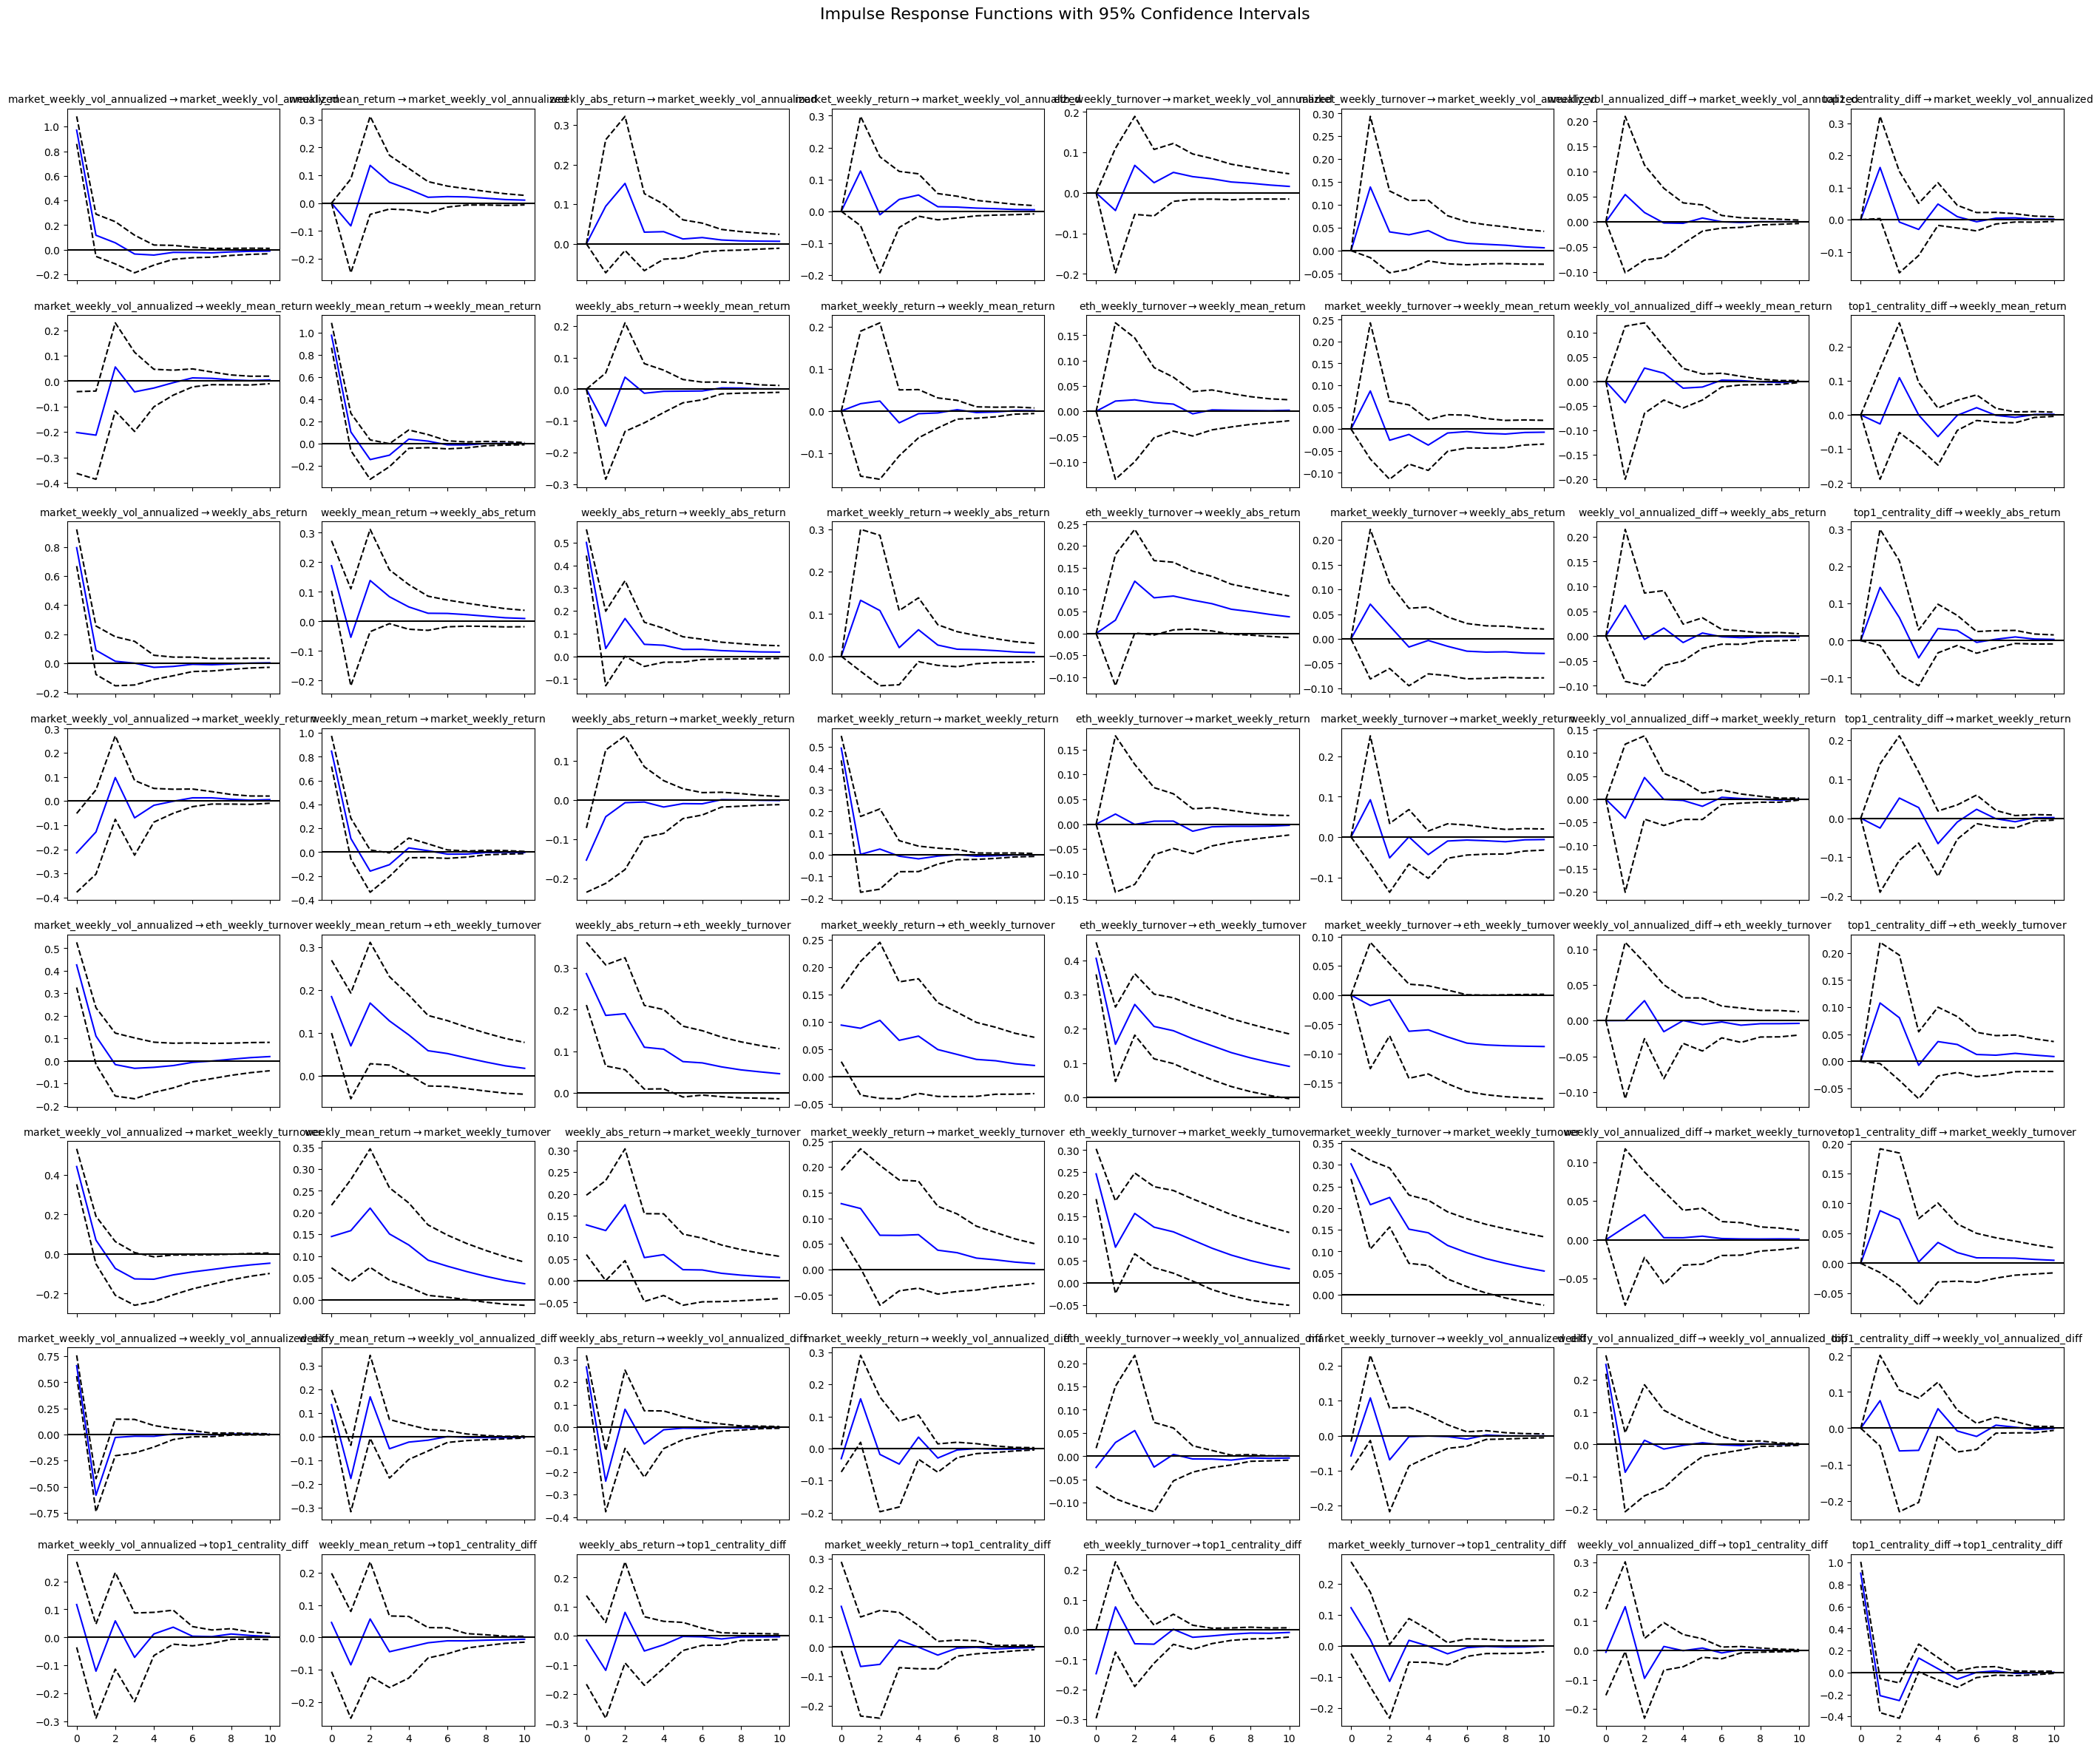

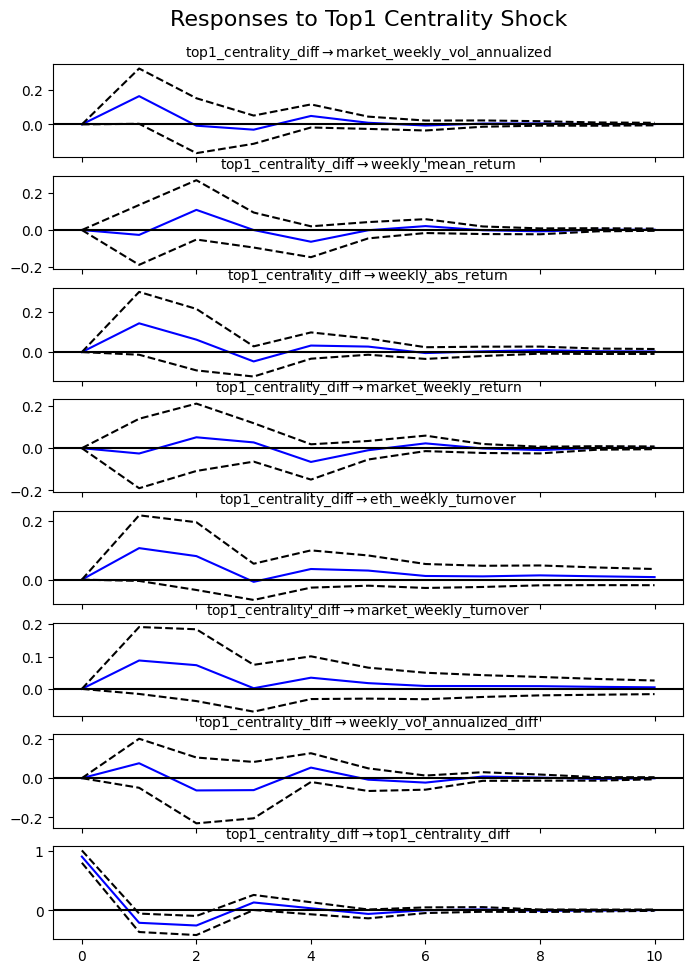

In [66]:
# =============================================================================
# IMPULSE RESPONSE FUNCTIONS (BUILT-IN METHOD)
# =============================================================================

print(f"\n{'='*60}")
print("PLOTTING IMPULSE RESPONSE FUNCTIONS")
print(f"{'='*60}")

# Use built-in IRF plotting with bootstrap confidence intervals
irf = var_model.irf(periods=10)

# Plot all IRFs with confidence bands
fig = irf.plot(orth=True, figsize=(30, 25), subplot_params={'fontsize': 10})
plt.suptitle('Impulse Response Functions with 95% Confidence Intervals', fontsize=16)
plt.savefig('../results/irf_all_variables.png', dpi=200, bbox_inches='tight')
plt.show()

# Plot only responses to network shock (top1_centrality_diff)
shock_idx = all_vars.index('top1_centrality_diff')
fig = irf.plot(orth=True, impulse=shock_idx, figsize=(7, 10), 
               subplot_params={'fontsize': 10})
plt.suptitle('Responses to Top1 Centrality Shock', fontsize=16)
plt.savefig('../results/irf_top1_centrality_shock.png', dpi=200, bbox_inches='tight')
plt.show()

In [42]:
# Variance decomposition
# Structural break analysis
